# Testing kmeans method with image windows

## Loading the image 

In [1]:
import commonmethods.image_modification as im

image = im.load_image_grayscale('5')

resized_image = im.resize_image(image, 1024)

## Method for getting the image windows

In [2]:
from matplotlib import pyplot as plt
import numpy as np

def get_window(row_number, column_number, px):
    window = np.zeros((px, px))

    for i in range(0, px):
        column = np.zeros((px))
        for j in range(0, px):
            column[j] = resized_image[row_number+i][column_number+j]
        window[i] = column
    
    return window

## Testing the above method and plotting the window

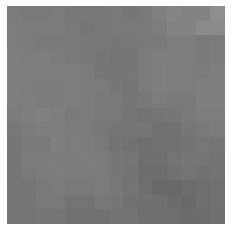

In [3]:
from matplotlib import pyplot as plt

px = 15

result_window = get_window(720,780, px)

plt.axis("off")

plt.imshow(result_window, cmap="gray", vmin=0, vmax=255)

## Tetsing the kmeans to different windows

In [4]:
import cv2

px = 15

window1 = get_window(658, 557, px)
window1 = window1.reshape((1, -1))
window2 = get_window(354, 610, px)
window2 = window2.reshape((1, -1))

Z = np.vstack((window1,window2,window1, window2, window2, window1))

values = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_images = centers[labels.flatten()]

#segmented_images = np.vsplit(segmented_images, 3)

print(labels)

[0 1 0 1 1 0]


In [5]:
import cv2

px = 15

window_avokado1 = get_window(658, 557, px)
window_avokado2 = get_window(595, 600, px)
window_background = get_window(354, 610, px)
window_vase1 = get_window(600, 360, px)
window_vase2 = get_window(700, 320, px)
window_paprika = get_window(720, 780, px)

window_avokado1 = window_avokado1.reshape((1, -1))
window_avokado2 = window_avokado2.reshape((1, -1))
window_background = window_background.reshape((1, -1))
window_vase1 = window_vase1.reshape((1, -1))
window_vase2 = window_vase2.reshape((1, -1))
window_paprika = window_paprika.reshape((1, -1))

Z = np.vstack((window_avokado1, window_avokado2, window_background, window_vase1, window_vase2, window_paprika))

values = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 4
_, labels, (centers) = cv2.kmeans(values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_images = centers[labels.flatten()]

print(labels)

[3 3 2 1 1 0]


## Getting the optimal cluster size

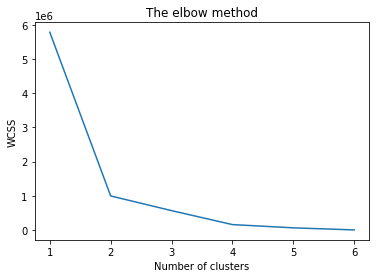

In [6]:
import commonmethods.image_modification as im

wcss = []   #within cluster sum of squares

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

for k in range(1, len(values)+1):
    compactness, _, _ = cv2.kmeans(values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    wcss.append(compactness)

plt.plot(range(1, len(values)+1), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [7]:
import commonmethods.image_modification as im
import commonmethods.optimal_cluster_number as ocn

#the best value and the cluster which resulted
s_closest = [0, 2]
db_min = [1000000, 2]
ch_max = [0, 2]

for i in range(2, len(values)):
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    _, labels, _ = cv2.kmeans(values, i, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    labels = labels.flatten()
    print(labels)

    s_time, s_score = ocn.silhouette_method(values, labels)
    db_time, db_score = ocn.davies_bouldin_method(values, labels)
    ch_time, ch_score = ocn.calinski_harabasz_method(values, labels)
    
    print("k: {}, S: {}, DB: {}, CH: {}".format(i, s_score, db_score, ch_score))
    
    #get the best cluster number for each methods
    if((1-s_score) < (1-s_closest[0])):
        s_closest = [s_score, i]

    if(db_score < db_min[0]):
        db_min = [db_score, i]

    if(ch_score > ch_max[0]):
        ch_max = [ch_score, i]
        
print(s_closest)
print(db_min)
print(ch_max)

[0 0 0 1 1 1]
k: 2, S: 0.6088057160377502, DB: 0.4148052230487001, CH: 19.27591941330653
[2 2 0 1 1 1]
k: 3, S: 0.4179699122905731, DB: 0.33764859417241966, CH: 13.868674952594644
[1 1 0 2 2 3]
k: 4, S: 0.31864070892333984, DB: 0.24687173714002478, CH: 24.12760728237983
[0 4 1 3 3 2]
k: 5, S: 0.1774878054857254, DB: 0.1418218489375813, CH: 23.532077658791206
[0.6088057, 2]
[0.1418218489375813, 5]
[24.12760728237983, 4]


## Get windows

In [8]:
def get_window_values(window_quantity, px, height, width):
    
    pixels = np.zeros((window_quantity, 2))
    
    x = np.random.randint(0, height-px, window_quantity)
    y = np.random.randint(0, width-px, window_quantity)
    
    for i in range(window_quantity):
        window = get_window(x[i], y[i], px)
        window = window.reshape((1, -1))
        pixels[i] = [x[i], y[i]] #saving the start pixels of the frames
        
        if i == 0:
            result = np.array(window)
        else:
            result = np.vstack([result, window])
    
    return result, pixels

In [165]:
def get_window_values_with_intensity(window_quantity, px, height, width):
    
    pixels = np.zeros((window_quantity, 2))
    
    x = np.random.randint(0, height-px, window_quantity)
    y = np.random.randint(0, width-px, window_quantity)
    
    for i in range(window_quantity):
        window = get_window(x[i], y[i], px)
        window = window.reshape((1, -1))
        
        window = np.append(window, [[np.mean(window)]], axis = 1)
        
        pixels[i] = [x[i], y[i]] #saving the start pixels of the frames
        
        if i == 0:
            result = np.array(window)
        else:
            result = np.vstack([result, window])
    
    return result, pixels

In [9]:
def color_windows(image, labels, pixels, px):
    colored_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    colors = np.array([[0, 0, 135],[255, 0, 0], [255, 255, 0],[255, 150, 0],[0, 255, 0]])
    
    for i in range(len(labels)):
        colored_image[int(pixels[i][0]):int(pixels[i][0]+px), int(pixels[i][1]):int(pixels[i][1]+px)] = colors[labels[i]]
    
    return colored_image

In [140]:
def segment_and_color_image(values, k, pixels, px):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, (centers) = cv2.kmeans(values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    segmented_image = centers[labels.flatten()]

    return color_windows(resized_image, labels.flatten(), pixels, px)

## Kmeans segmentation by texture (feature vector)

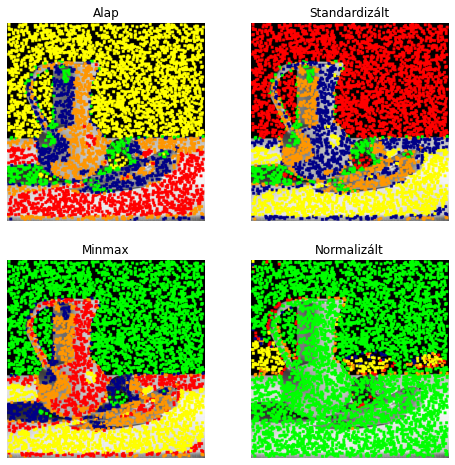

In [169]:
import cv2
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

px = 15
height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values(5000, px, height, width)

window_values = np.float32(window_values)

colored_base_image = segment_and_color_image(window_values, 5, pixels, px)

fig = plt.figure(figsize=(8,8))

image1 = fig.add_subplot(2,2,1)
image1.axis("off")
image1.set_title("Alap")
image1.imshow(colored_base_image, cmap="gray", vmin=0, vmax=255)

scale = StandardScaler()
scaled_data = scale.fit_transform(window_values)

colored_standard_image = segment_and_color_image(scaled_data, 5, pixels, px)

image2 = fig.add_subplot(2,2,2)
image2.axis("off")
image2.set_title("Standardizált")
image2.imshow(colored_standard_image, cmap="gray", vmin=0, vmax=255)
 
min_max_scaler = MinMaxScaler()
minmax = min_max_scaler.fit_transform(window_values)

colored_minmax_image = segment_and_color_image(minmax, 5, pixels, px)

image3 = fig.add_subplot(2,2,3)
image3.axis("off")
image3.set_title("Minmax")
image3.imshow(colored_minmax_image, cmap="gray", vmin=0, vmax=255)

normalized = normalize(window_values, norm='l2')

colored_normalize_image = segment_and_color_image(normalized, 5, pixels, px)

image4 = fig.add_subplot(2,2,4)
image4.axis("off")
image4.set_title("Normalizált")
image4.imshow(colored_normalize_image, cmap="gray", vmin=0, vmax=255)

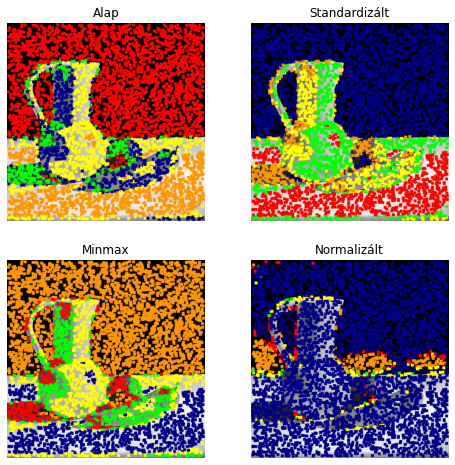

In [168]:
import cv2
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

px = 15
height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values_with_intensity(5000, px, height, width)

window_values = np.float32(window_values)

colored_base_image = segment_and_color_image(window_values, 5, pixels, px)

fig = plt.figure(figsize=(8,8))

image1 = fig.add_subplot(2,2,1)
image1.axis("off")
image1.set_title("Alap")
image1.imshow(colored_base_image, cmap="gray", vmin=0, vmax=255)

scale = StandardScaler()
scaled_data = scale.fit_transform(window_values)

colored_standard_image = segment_and_color_image(scaled_data, 5, pixels, px)

image2 = fig.add_subplot(2,2,2)
image2.axis("off")
image2.set_title("Standardizált")
image2.imshow(colored_standard_image, cmap="gray", vmin=0, vmax=255)
 
min_max_scaler = MinMaxScaler()
minmax = min_max_scaler.fit_transform(window_values)

colored_minmax_image = segment_and_color_image(minmax, 5, pixels, px)

image3 = fig.add_subplot(2,2,3)
image3.axis("off")
image3.set_title("Minmax")
image3.imshow(colored_minmax_image, cmap="gray", vmin=0, vmax=255)

normalized = normalize(window_values, norm='l2')

colored_normalize_image = segment_and_color_image(normalized, 5, pixels, px)

image4 = fig.add_subplot(2,2,4)
image4.axis("off")
image4.set_title("Normalizált")
image4.imshow(colored_normalize_image, cmap="gray", vmin=0, vmax=255)

## KNN classaification

[0]


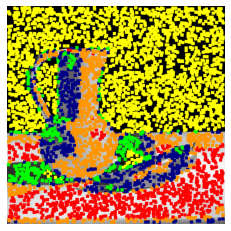

In [126]:
from sklearn.neighbors import KNeighborsClassifier

px = 15
height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values(5000, px, height, width)

window_values = np.float32(window_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 5
_, labels, (centers) = cv2.kmeans(window_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

labels = labels.flatten()

segmented_image = centers[labels.flatten()]

cl_image = color_windows(resized_image, labels.flatten(), pixels, px)

plt.axis("off")

plt.imshow(cl_image)

knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(window_values, labels)

test_window = get_window(300, 300, px)

test_window = test_window.reshape((1, -1))

predicted= knn_model.predict(test_window)
print(predicted)

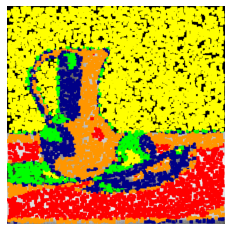

In [127]:
plus_window_values, plus_pixels = get_window_values(5000, px, height, width)

plus_labels = np.empty(5000, dtype=int)

for i in range(len(plus_window_values)):
    test_window = plus_window_values[i].reshape((1, -1))

    predicted = knn_model.predict(test_window)
            
    plus_labels[i] = int(predicted)
    
plus_cl_image = cl_image

colors = np.array([[0, 0, 135],[255, 0, 0], [255, 255, 0],[255, 150, 0],[0, 255, 0]])
    
for i in range(len(plus_labels)):
    plus_cl_image[int(plus_pixels[i][0]):int(plus_pixels[i][0]+px), int(plus_pixels[i][1]):int(plus_pixels[i][1]+px)] = colors[plus_labels[i]]

plt.axis("off")

plt.imshow(plus_cl_image)

In [187]:
#np.any(np.all(array_to_check == list_np_arrays, axis=1))

test_pixels = []
test_labels = []

for i in range(height-px):
    for j in range(width-px):
        if(cl_image[i][j][0] == cl_image[i][j][1] and cl_image[i][j][0] == cl_image[i][j][2]):
            test_window = get_window(i, j, px)

            test_window = test_window.reshape((1, -1))

            predicted = knn_model.predict(test_window)
            
            test_pixels.append([i, j])
            
            test_labels.append(predicted)
            
print(test_pixels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



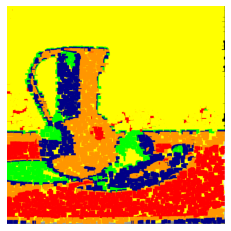

In [192]:
colored_image_test = cl_image

colors = np.array([[0, 0, 135],[255, 0, 0], [255, 255, 0],[255, 150, 0],[0, 255, 0]])
    
for i in range(len(test_labels)):
    colored_image_test[int(test_pixels[i][0]):int(test_pixels[i][0]+px), int(test_pixels[i][1]):int(test_pixels[i][1]+px)] = colors[test_labels[i]]

plt.axis("off")

plt.imshow(cl_image)